# GRU2

## Imports

In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
# from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import tensorflow as tf


## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import GRU
from keras.layers import Dropout

import wandb
import os
from wandb.keras import WandbCallback
wandb.init(project="smartgridai-gru-open")


Using TensorFlow backend.
wandb: WARNING Keras version 2.3.1 is not fully supported. Required keras >= 2.4.0
wandb: Currently logged in as: maxiicano (use `wandb login --relogin` to force relogin)


## Data observation

In [2]:
# load data from text file
df = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
## finding all columns that have nan:
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [5]:
# Filling empty data with mean for test purposes, better solution comes later
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [6]:
# Check if any NaN are left
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [7]:
# split into train and test sets
values = df.values

columns = [x for x in df.columns if x not in "Global_active_power"]

train_X, test_X, train_y, test_y = train_test_split(df[columns].values, df["Global_active_power"].values, test_size=0.2, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by GRUs, namely [samples, timesteps, features].
print(df["Global_active_power"].values)
print(df[columns].values)

(1245155, 1, 6) (1245155,) (415052, 1, 6) (415052,)
[4.216 5.36  5.374 ... 0.938 0.934 0.932]
[[  0.418 234.84   18.4     0.      1.     17.   ]
 [  0.436 233.63   23.      0.      1.     16.   ]
 [  0.498 233.29   23.      0.      2.     17.   ]
 ...
 [  0.    239.82    3.8     0.      0.      0.   ]
 [  0.    239.7     3.8     0.      0.      0.   ]
 [  0.    239.55    3.8     0.      0.      0.   ]]


Train on 1245155 samples, validate on 415052 samples
Epoch 1/10
 - 17s - loss: 0.0670 - val_loss: 0.0032
Epoch 2/10
 - 3s - loss: 0.0114 - val_loss: 0.0030
Epoch 3/10
 - 3s - loss: 0.0101 - val_loss: 0.0040
Epoch 4/10
 - 3s - loss: 0.0090 - val_loss: 0.0035
Epoch 5/10
 - 3s - loss: 0.0085 - val_loss: 0.0034
Epoch 6/10
 - 3s - loss: 0.0079 - val_loss: 0.0031
Epoch 7/10
 - 3s - loss: 0.0075 - val_loss: 0.0033
Epoch 8/10
 - 3s - loss: 0.0072 - val_loss: 0.0031
Epoch 9/10
 - 3s - loss: 0.0070 - val_loss: 0.0024
Epoch 10/10
 - 3s - loss: 0.0067 - val_loss: 0.0031


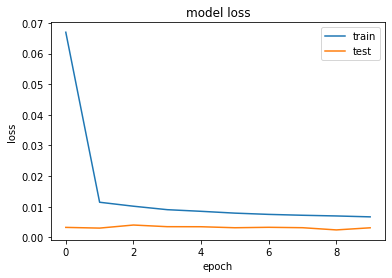

In [8]:
model = Sequential()
model.add(GRU(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=1500, validation_data=(val_X, val_y), verbose=2, shuffle=False, callbacks=[WandbCallback()])
model.save(os.path.join(wandb.run.dir, "model.h5"))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# Predicting

In [9]:
# make a prediction
yhat = model.predict(test_X)
print(yhat)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


[[1.3887337]
 [0.8018755]
 [0.7309925]
 ...
 [1.9411429]
 [1.2249815]
 [0.4915219]]
Test RMSE: 0.056
